# Case Study: Bay Area Airbnb Dataset

# MVP: Airbnb Rental Price Estimator

Our goal is to deploy a machine learning model that can estimate with reasonable accuracy an appropriate rental rate for an Airbnb property in Santa Clara County, CA. This minimum viable product will be able to provide the user with a rental rate estimate based only on the most relevant features of their property, such as the type of property and the number of bedrooms.

- Part 1. Data Exploration and Preprocessing
    - Sections 1-11 explore the relationship between various input variables and `price`
- Part 2. Building the Model
- Part 3. Seeing the Model in Action
- Part 4. Improvement Opportunities

# Part 1. Data Exploration and Preprocessing

### Imports

The following imports will be utilized throughout the notebook, not just in this first section.

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read in data
df = pd.read_csv("Airbnb_Listings.csv")
print(f"DataFrame length is: {len(df)}")
print(df.property_type.value_counts())

DataFrame length is: 7221
House                 3715
Apartment             1152
Serviced apartment     504
Townhouse              429
Guest suite            363
Guesthouse             318
Condominium            303
Villa                  129
Bungalow               115
Loft                    41
Cottage                 29
Camper/RV               27
Boutique hotel          23
Tiny house              16
Other                   13
Bed and breakfast       12
Cabin                    7
Farm stay                6
Tent                     5
Treehouse                3
Yurt                     3
Barn                     2
Train                    1
Lighthouse               1
Campsite                 1
Earth house              1
Aparthotel               1
Chalet                   1
Name: property_type, dtype: int64


We will have our model focus only on the most common types of property offered on Airbnb: **houses** and **apartments**. Unfortunately, the data available for yurts, tents, boutique hotels, and *yes*, even trains, is quite sparce. For this reason, we will train our model on the most common property types, since the model will be less affected by outlier property types.

In [3]:
# Limit model to houses and apartments
df = df[df['property_type'].isin(['House', 'Apartment'])]

In [4]:
# See how many houses and apartments we have
df.property_type.value_counts()

House        3715
Apartment    1152
Name: property_type, dtype: int64

### Preprocessing the `price` column

Because the `price` column contains strings of the form `'$ddd.cc'`, we want to transform them into floats that we can easily process. The code below replaces the dollar signs and commas, converts the `dtype` to numeric, and displays the mean and average prices for houses and apartments.

In [5]:
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)

# Convert the price column to numeric
df['price'] = pd.to_numeric(df['price'])

# Calculate the median price for Houses
house_med_price = df[df['property_type'] == 'House']['price'].median()

# Calculate the average price for Apartments
apartment_med_price = df[df['property_type'] == 'Apartment']['price'].median()

print(f'Median price for Houses: {house_med_price}')
print(f'Median price for Apartments: {apartment_med_price}')

# Calculate the average price for Houses
house_avg_price = df[df['property_type'] == 'House']['price'].mean()

# Calculate the average price for Apartments
apartment_avg_price = df[df['property_type'] == 'Apartment']['price'].mean()

print(f'Average price for Houses: {round(house_avg_price, 2)}')
print(f'Average price for Apartments: {round(apartment_avg_price, 2)}')

Median price for Houses: 77.0
Median price for Apartments: 125.0
Average price for Houses: 156.24
Average price for Apartments: 150.6


The prices of houses and apartments have different central tendencies, with houses generally having lower median and higher mean prices compared to apartments. This suggests that there are a some very expensive houses that are bringing the mean up. Also, the relatively low median price for houses may be due to the fact that many owners rent out individual rooms within houses, so in this case a cheaper room might be classified under houses.

## 1. Visualizing the spread of `price` by `property_type`

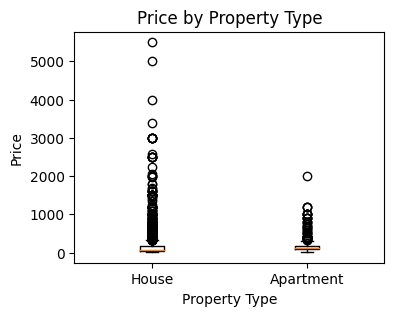

In [6]:
plt.figure(figsize=(4, 3))

# Using a box plot to visualize the spread of prices
plt.boxplot([df['price'][df['property_type'] == 'House'], df['price'][df['property_type'] == 'Apartment']],
            labels=['House', 'Apartment'])

plt.title('Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.show()

As we can clearly see from the boxplot, there are quite a few expensive outliers for both houses and apartments, but notably for houses. These outliers make it almost impossible to interpret the price distribution. To get another perspective, see the following histogram:

### Visualizing the `price` distribution by `property_type` via histogram

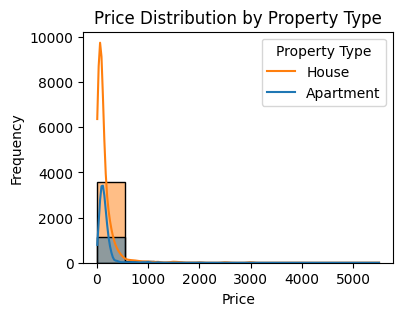

In [7]:
plt.figure(figsize=(4, 3))
sns.histplot(data=df, x='price', bins=10, kde=True, hue='property_type')
plt.title('Price Distribution by Property Type')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend(title='Property Type', labels=['House', 'Apartment'])
plt.show()

Like the boxplot showed, the histogram also shows that there are major price outliers. For the purposes of improved model performance, we will focus on properties with a `price` of less than or equal to 350. The reason I picked this value is because the vast majority of the data lies below this price point. Also, model performance (which will be discussed later) peaks at this value.

### See the number of points with `price` greater than 350

In [8]:
# Count the rows with a price over $350
count_over_350 = len(df[df['price'] > 350])

# Display the count
print("Number of rows with a price over $350:", count_over_350)

Number of rows with a price over $350: 326


In [9]:
# Remove rows where price is over 350
df = df[df['price'] <= 350]

### Visualizing the `price` distribution after removing outliers

Now that we have removed extreme price outliers, the histogram of `price` distribution by `property_type` is much more readable and informative. We can see that there are many more houses (or rooms within houses) than apartments, and that the `price` peak for houses occurs at a cheaper point than it does for apartments. Again, this is probably due to the fact that owners rent out individual rooms or sections of their homes.

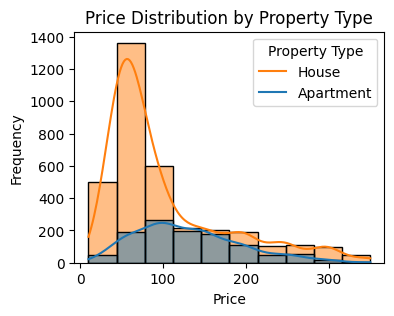

In [10]:
plt.figure(figsize=(4, 3))
sns.histplot(data=df, x='price', bins=10, kde=True, hue='property_type')
plt.title('Price Distribution by Property Type')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend(title='Property Type', labels=['House', 'Apartment'])
plt.show()

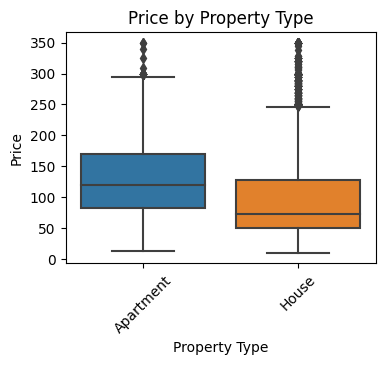

In [11]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='property_type', y='price', data=df)
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.title('Price by Property Type')
plt.xticks(rotation=45)
plt.show()

## 2. Visualizing `price` by `neighbourhood_cleansed` (city)

Regarding the use of the column `neighbourhood_cleansed`, it is the case that this dataset contains a lot of redundant and messy location-related columns. The columns `city`, `neighbourhood`, and `smart_location` all contain messy versions of the data in `neighbourhood_cleansed`. For example, you may see both `'San jose'` and `'San Jose, CA'` in the `city` column. Owing to this inconsistent formatting, we use `neighbourhood_cleansed` to easily reference the cities in the dataset.

We can create a barplot of median prices of houses and apartments by neighborhood (city).

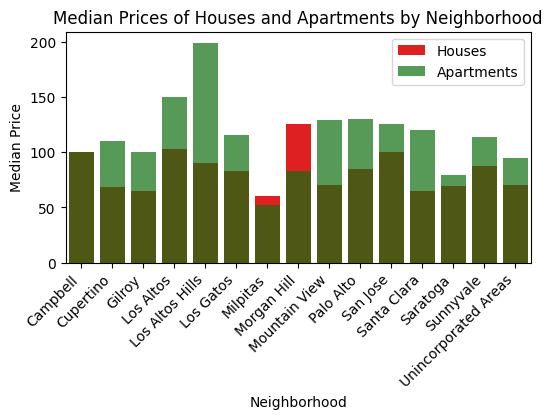

In [12]:
houses = df[df['property_type'] == 'House']
apartments = df[df['property_type'] == 'Apartment']

house_prices_by_neighborhood = houses.groupby('neighbourhood_cleansed')['price'].median().reset_index()
apartment_prices_by_neighborhood = apartments.groupby('neighbourhood_cleansed')['price'].median().reset_index()

# Create a bar plot with dodge
plt.figure(figsize=(6, 3))
ax = sns.barplot(x='neighbourhood_cleansed', y='price', data=house_prices_by_neighborhood, label='Houses', dodge=True, color='r')
sns.barplot(x='neighbourhood_cleansed', y='price', data=apartment_prices_by_neighborhood, label='Apartments', dodge=True, color='g', alpha=0.7)
plt.xlabel('Neighborhood')
plt.ylabel('Median Price')
plt.title('Median Prices of Houses and Apartments by Neighborhood')
plt.legend()

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

Interestingly, the price of apartments exceeds the price of houses is all but two neighborhoods, Milpitas and Morgan Hill. It may be the case that these two neighborhoods have a higher percentage of single-family housing stock than apartment stock. Regarding apartment price outliers, areas with high cost are Los Altos and Los Altos Hills, and areas with lower cost are Milpitas and Saratoga. Regarding house price outliers, Morgan Hill is particularly expensive.

### Where are the houses concentrated?

To get a better idea of where most of the houses are located, we plot the number of houses by neighborhood:

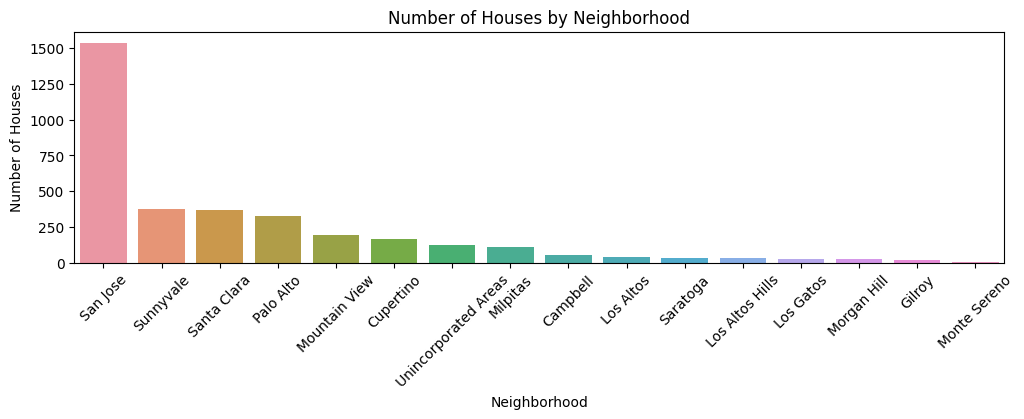

In [13]:
# Filter the DataFrame to include only houses
houses_df = df[df['property_type'] == 'House']

plt.figure(figsize=(12, 3))
sns.countplot(data=houses_df, x='neighbourhood_cleansed', order=houses_df['neighbourhood_cleansed'].value_counts().index)
plt.xlabel('Neighborhood')
plt.ylabel('Number of Houses')
plt.title('Number of Houses by Neighborhood')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Interestingly, the vast majority of houses are located in San Jose. We see a pretty big dropoff in count around Milpitas. It turns out that removing neighborhoods with fewer than 50 houses improves model performance. The only outlier neighborhood in this case is Monte Sereno, with fewer than 50 houses.

In [14]:
# Calculate the counts of houses in each neighborhood
neighborhood_counts = df[df['property_type'] == 'House']['neighbourhood_cleansed'].value_counts()

# Identify neighborhoods with counts less than 50
neighborhoods_to_remove = neighborhood_counts[neighborhood_counts < 50].index

# Create a mask to filter out rows corresponding to these neighborhoods
mask = (df['property_type'] != 'House') | (~df['neighbourhood_cleansed'].isin(neighborhoods_to_remove))

# Apply the mask to the DataFrame to keep only the desired rows
df = df[mask]

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

We now pivot to examine the same distribution, but with regard to apartments. We see a similar heavy concentration of units in San Jose, but the counts are a bit closer together (i.e. there isn't as sharp a dropoff from San Jose to the neighborhood with the next highest count).

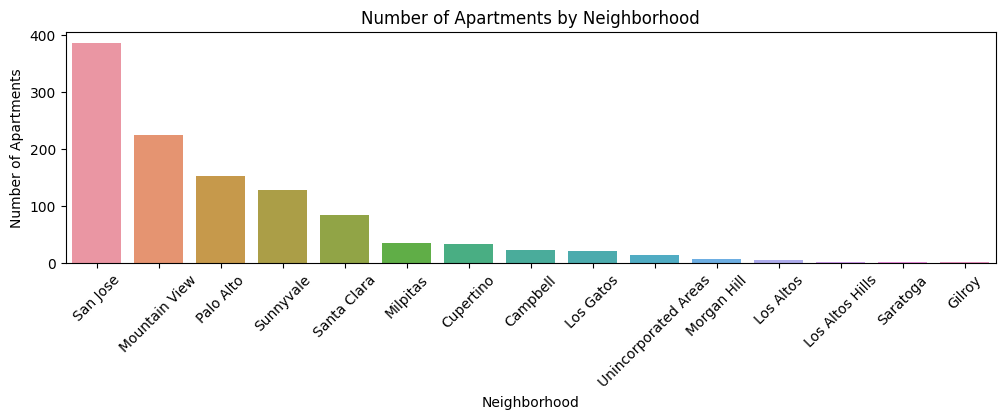

In [15]:
# Filter the DataFrame to include only apartments
apartments_df = df[df['property_type'] == 'Apartment']

plt.figure(figsize=(12, 3))
sns.countplot(data=apartments_df, x='neighbourhood_cleansed', order=apartments_df['neighbourhood_cleansed'].value_counts().index)
plt.xlabel('Neighborhood')
plt.ylabel('Number of Apartments')
plt.title('Number of Apartments by Neighborhood')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Interestingly, removing neighborhoods with low apartment counts does not significantly improve model performance. This is probably because those neighborhoods have a higher proportion of houses. For this reason, we leave the neighborhoods as is.

## 3. Visualizing `price` by `latitude` and `longitude`

Using `latitude` and `longitude` as predictor variables is an interesting idea because they may offer some more granular detail than the `neighbourhood_cleansed` (city) variable. The plots of `price` by `latitude` and `longitude` turn out to look quite muddy. Nevertheless, including them as input variables actually does improve model performance by a small margin.

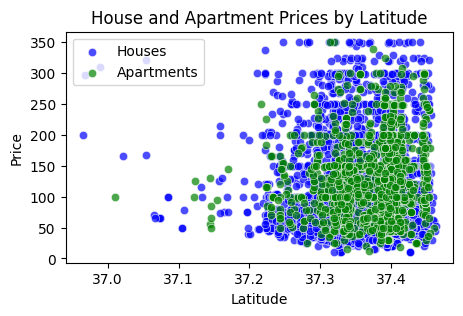

In [16]:
# Create separate DataFrames for houses and apartments
houses = df[df['property_type'] == 'House']
apartments = df[df['property_type'] == 'Apartment']

plt.figure(figsize=(5, 3))
sns.scatterplot(x='latitude', y='price', data=houses, label='Houses', color='b', alpha=0.7)
sns.scatterplot(x='latitude', y='price', data=apartments, label='Apartments', color='g', alpha=0.7)
plt.xlabel('Latitude')
plt.ylabel('Price')
plt.title('House and Apartment Prices by Latitude')
plt.legend()
plt.show()

It turns out that by removing outlier listings at `latitude`s less than or equal to 37.2, model performance improves, so we do that here:

In [17]:
df = df[df['latitude'] > 37.2]
df.reset_index(drop=True, inplace=True)

The code below plots `price` by `longitude`:

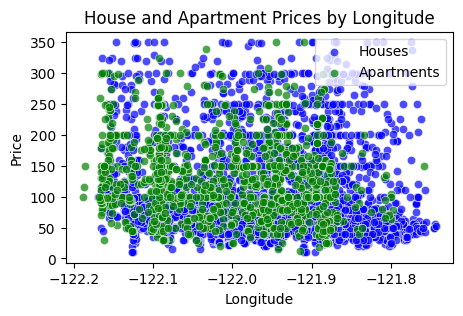

In [18]:
# Create separate DataFrames for houses and apartments
houses = df[df['property_type'] == 'House']
apartments = df[df['property_type'] == 'Apartment']

plt.figure(figsize=(5, 3))
sns.scatterplot(x='longitude', y='price', data=houses, label='Houses', color='b', alpha=0.7)
sns.scatterplot(x='longitude', y='price', data=apartments, label='Apartments', color='g', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Price')
plt.title('House and Apartment Prices by Longitude')
plt.legend()
plt.show()

Outlier latitudes, which were previously removed, corresponded to outlier longitudes, which is why this plot looks more evenly distributed. Again, even though the plots look quite muddled, their inclusion does help improve the model's performance. Latitude has a slight position correlation with price, whereas longtitude has a slight negative correlation with price.

To help simplify the `latitude` and `longitude` values, we scale them via the `MinMaxScaler`.

In [19]:
scaler = MinMaxScaler()
# Normalize latitude and longitude columns
df[['latitude', 'longitude']] = scaler.fit_transform(df[['latitude', 'longitude']])

## 4. Examining `price` by `room_type`

It turns out that `room_type` is a critical input variable for model performance. There are three room types available: `Private room`, `Entire home/apt`, and `Shared room`. See their counts below:

In [20]:
df.room_type.value_counts()

Private room       2532
Entire home/apt    1515
Shared room         278
Name: room_type, dtype: int64

To visualize the distribution of `price` by `room_type`, we make use of the following boxplot:

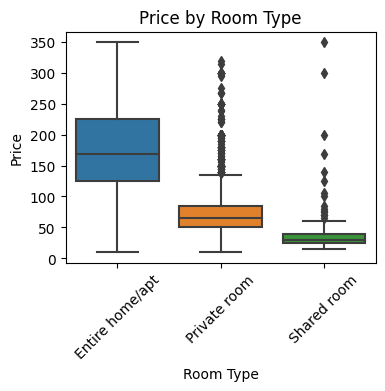

In [21]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='room_type', y='price', data=df)
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.title('Price by Room Type')
plt.xticks(rotation=45)
plt.show()

We can also visualize the frequency of different room types by price using the histogram below:

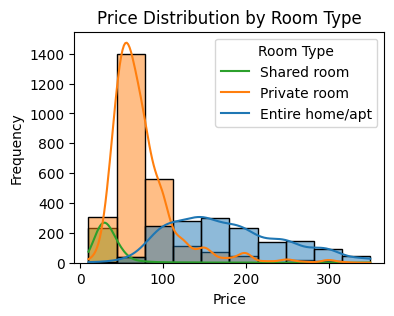

In [22]:
plt.figure(figsize=(4, 3))
sns.histplot(data=df, x='price', bins=10, kde=True, hue='room_type')
plt.title('Price Distribution by Room Type')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend(title='Room Type', labels=['Shared room', 'Private room', 'Entire home/apt'])
plt.show()

Regarding the boxplot, we see that private rooms and shared rooms have some outliers, and the histograms' long tails to the right confirm that there are some high-priced outliers for these two room types. In the same way that high-priced `property_type` outliers bogged down model performance, so do these `room_type` outliers. For this reason, we filter them out in the code below:

In [23]:
# Filter rows to exclude private room and price over 120
df = df[~((df['room_type'] == 'Private room') & (df['price'] > 120))]
df.reset_index(drop=True, inplace=True)


# Filter rows to exclude shared room and price over 50
df = df[~((df['room_type'] == 'Shared room') & (df['price'] > 50))]
df.reset_index(drop=True, inplace=True)

# Filter rows to exclude entire place and price under 75
df = df[~((df['room_type'] == 'Entire home/apt') & (df['price'] < 75))]
df.reset_index(drop=True, inplace=True)

In [24]:
df.room_type.value_counts()

Private room       2316
Entire home/apt    1482
Shared room         260
Name: room_type, dtype: int64

## 5. Looking at `price` by `accommodates`

The `accommodates` column in the dataset is a numeric column that describes how many guests the unit can accommodate. This variable plays a major role in model performance because it has a clearer linear relationship to `price` than other variables. The scatterplot below illustrates this relationship:

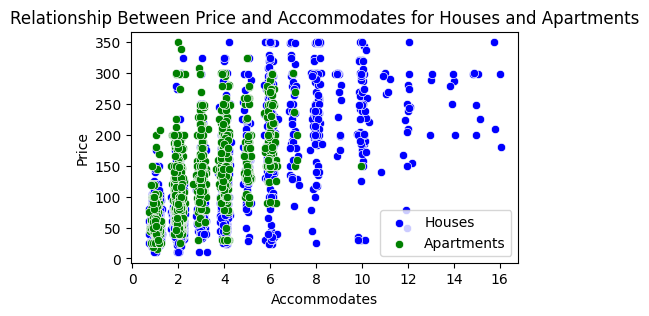

In [25]:
# Create separate DataFrames for houses and apartments
houses = df[df['property_type'] == 'House']
apartments = df[df['property_type'] == 'Apartment']

plt.figure(figsize=(5, 3))

# Add jitter to scatter plot for houses
sns.scatterplot(x=houses['accommodates'] + np.random.normal(0, 0.1, len(houses)), y='price', data=houses, label='Houses', color='b')

# Add jitter to scatter plot for apartments
sns.scatterplot(x=apartments['accommodates'] + np.random.normal(0, 0.1, len(apartments)), y='price', data=apartments, label='Apartments', color='g')

plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.title('Relationship Between Price and Accommodates for Houses and Apartments')
plt.legend()
plt.show()

To get another perspective of this distribution, we can create a lineplot of the mean prices of houses and apartments by `accommodates`:

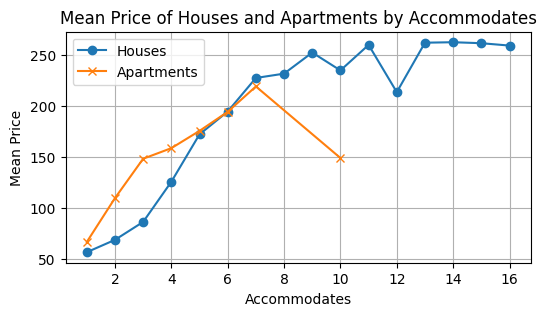

In [26]:
# Group the data by property_type and accommodates, then calculate the mean price
mean_prices = df.groupby(['property_type', 'accommodates'])['price'].mean().reset_index()

# Separate the data for houses and apartments
houses = mean_prices[mean_prices['property_type'] == 'House']
apartments = mean_prices[mean_prices['property_type'] == 'Apartment']

plt.figure(figsize=(6, 3))

# Plot the mean prices for houses
plt.plot(houses['accommodates'], houses['price'], label='Houses', marker='o')

# Plot the mean prices for apartments
plt.plot(apartments['accommodates'], apartments['price'], label='Apartments', marker='x')

plt.xlabel('Accommodates')
plt.ylabel('Mean Price')
plt.title('Mean Price of Houses and Apartments by Accommodates')
plt.legend()
plt.grid(True)
plt.show()

Here we see that the relationship is linear until around 8 people accommodated. It turns out properties accommodating more than 8 people are uncommon. Therefore we remove them as outliers:

In [27]:
# Count the number of rows where 'accommodates' is greater than 8
count_accommodates_gt_8 = len(df[df['accommodates'] > 8])

print("Number of rows where 'accommodates' > 8:", count_accommodates_gt_8)

Number of rows where 'accommodates' > 8: 112


In [28]:
df = df[df['accommodates'] < 9]

With outliers from `accommodates` removed, the plot of mean `price`s by `accommodates` can be viewed below:

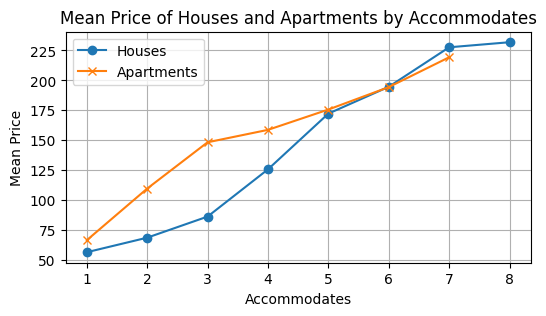

In [29]:
# Group the data by property_type and accommodates, then calculate the mean price
mean_prices = df.groupby(['property_type', 'accommodates'])['price'].mean().reset_index()

# Separate the data for houses and apartments
houses = mean_prices[mean_prices['property_type'] == 'House']
apartments = mean_prices[mean_prices['property_type'] == 'Apartment']

plt.figure(figsize=(6, 3))

# Plot the mean prices for houses
plt.plot(houses['accommodates'], houses['price'], label='Houses', marker='o')

# Plot the mean prices for apartments
plt.plot(apartments['accommodates'], apartments['price'], label='Apartments', marker='x')

plt.xlabel('Accommodates')
plt.ylabel('Mean Price')
plt.title('Mean Price of Houses and Apartments by Accommodates')
plt.legend()
plt.grid(True)
plt.show()

## 6. Examining the relationship between `price` and `bedrooms`

The violin plot below shows the distribution of `bedrooms` by `property_type`. I chose to represent the data in violin plots so that it's easier to visualize the size of bedroom counts:

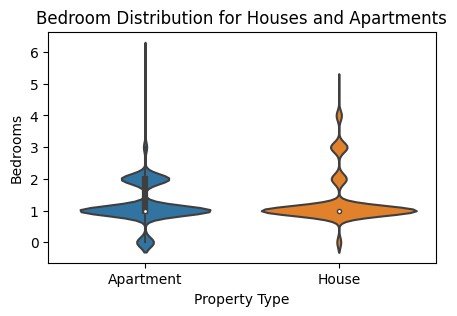

In [30]:
plt.figure(figsize=(5, 3))

sns.violinplot(x='property_type', y='bedrooms', data=df)
plt.xlabel('Property Type')
plt.ylabel('Bedrooms')
plt.title('Bedroom Distribution for Houses and Apartments')
plt.show()

It turns out that the number of properties (houses and apartments together) with 5 or more bedrooms is quite small, as shown below:

In [31]:
# Count the number of properties with 5 or more bedrooms
num_properties_with_5_or_more_bedrooms = (df['bedrooms'] >= 5).sum()

print("Number of properties with 5 or more bedrooms:", num_properties_with_5_or_more_bedrooms)

Number of properties with 5 or more bedrooms: 6


To control for outliers and improve model performance, we filter out rows where apartments have 4 or more bedrooms, and where houses have 5 or more bedrooms. Using unique filters (one for houses and one for apartments) helps to better capture the relationship between `property_type` and `bedrooms`.

In [32]:
# Filter rows where property_type is not 'Apartment' or bedrooms are not greater than 4
df = df[(df['property_type'] != 'Apartment') | (df['bedrooms'] < 4)]
df.reset_index(drop=True, inplace=True)

# Filter rows where property_type is not 'House' or bedrooms are not greater than 5
df = df[(df['property_type'] != 'House') | (df['bedrooms'] < 5)]
df.reset_index(drop=True, inplace=True)

## 7. Examining the relationship between `price` and `bathrooms`

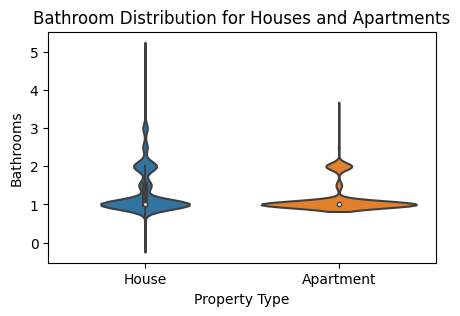

In [33]:
plt.figure(figsize=(5, 3))

sns.violinplot(x='property_type', y='bathrooms', data=df)
plt.xlabel('Property Type')
plt.ylabel('Bathrooms')
plt.title('Bathroom Distribution for Houses and Apartments')
plt.show()

Again, to control for outliers and improve model performance, we filter out rows with 4 or more bathrooms.

In [34]:
df = df[df['bathrooms'] < 4]

Now that we have established the distribution of bedroom and bathroom counts with respect to `property_type`, we can look at the relationship between `bedrooms` and `price`, and `bathrooms` and `price`.

Below, a jittered scatterplot depicting the relationship between `bedrooms` and `price` follows a nice linear pattern.

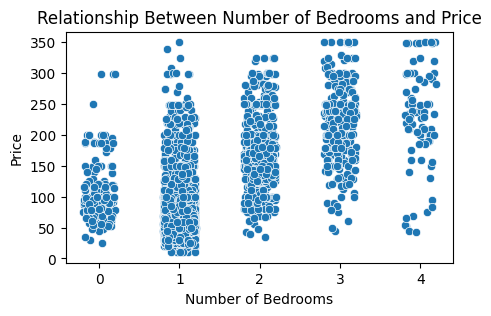

In [35]:
plt.figure(figsize=(5, 3))

jittered_bedrooms = df['bedrooms'] + np.random.uniform(-0.2, 0.2, len(df))
sns.scatterplot(x=jittered_bedrooms, y='price', data=df)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.title('Relationship Between Number of Bedrooms and Price')
plt.show()

Conversely, and rather interestingly, the relationship between `bathrooms` and `price` does not appear to be linear. The jittered scatterplot below illustrates this relationship. In fact, we do not include the number of bathrooms in the final model, precisely because it does not reliably help to predict `price`.

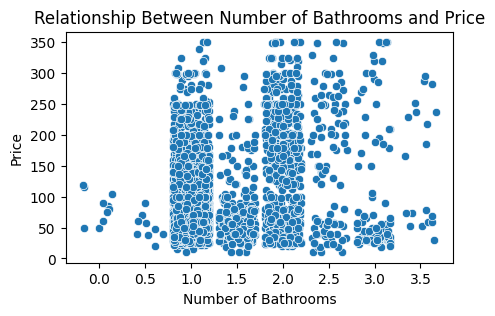

In [36]:
plt.figure(figsize=(5, 3))

jittered_bedrooms = df['bathrooms'] + np.random.uniform(-0.2, 0.2, len(df))
sns.scatterplot(x=jittered_bedrooms, y='price', data=df)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')
plt.title('Relationship Between Number of Bathrooms and Price')
plt.show()

Interesting!

## 8. Examining the `zipcode` column and its relationship to `price`

It turns out that `zipcode` is not a great predictor of price, which seems counterintuitive at first. But, thinking more carefully about the fact that bedroom count, `room_type`, and `accommodates` are much better predictors of price, as well as considering the diversity of listings in each `zipcode`, it follows that each `zipcode` may not capture enough granular detail about the listings within it, and that happens to be the case. If, for example, we were analyzing a dataset of single-family home real estate figures, a `zipcode` column would probably prove to be much more informative. Nevertheless, I still include my process of cleaning and organizing the `zipcode` column in this section, since we will filter out outlying ZIP codes to improve model performance.

We begin by taking a look at all the unique ZIP codes in the dataset, and see that this column is messy, containing `NaN`s and misformatted ZIP codes.

In [37]:
df.zipcode.unique()

array(['94301', '95117', '94086', '95112', '95008', '95014', '95051',
       '94040', '95130', '95035', '94303', '94306', '95124', '95132',
       '95032', '94041', '95122', '94043', '95111', '95128', '94085',
       '94089', '95148', '95125', nan, '95118', '95030', '95127', '95126',
       '95054', '95110', '94087', '95070', '95134', '95136', '95121',
       '95129', '95131', '95050', '95119', '94022', '95139', '95123',
       '95116', '95120', '95135', '95002', '95133', '95138', '94304',
       '94024', '95215', '95113', '9503\n9503\n95035', '94025', '94305',
       '95124-3403', '95140', 'CA 94041', 'CA 95126', 'CA 94040', '95086',
       '94539', 'CA 94043', 'CA 94306', 'CA 94087', 'CA 95050',
       'CA 95014', 'CA 95128', 'CA 94086', 'CA 95054', 'CA 95051'],
      dtype=object)

The code below formats ZIP codes by:
- removing any prefixes
- removing any ZIP+4 codes using `regex`
- manually fixing badly misformatted ZIP codes

In [38]:
# Remove 'CA ' prefix from the "zipcode" column
df['zipcode'] = df['zipcode'].str.replace('CA ', '', regex=False)

# Remove the extra '-xxxx' part from the "zipcode" column
df['zipcode'] = df['zipcode'].str.replace(r'-\d{4}$', '', regex=True)

# Find the row where "zipcode" appears as '9503\n9503\n95035'
row_to_update = df[df['zipcode'] == '9503\n9503\n95035'].index[0]

# Update the "zipcode" value to retain only the last five digits
df.loc[row_to_update, 'zipcode'] = '95035'

There are very few `NaN` values in the `zipcode` column. We impute their values using the most common ZIP code in their corresponding `neighbourhood_cleansed` (city).

In [39]:
# Group the DataFrame by neighbourhood_cleansed and calculate the mode zipcode (if such a zipcode is available)
def mode_zipcode(x):
    # Check if there are non-null values in the group
    if x.notnull().any():
        return x.mode().iat[0]
    else:
        return None

# Explicitly specify the data type as 'str' when creating the DataFrame
mode_zipcodes = df.groupby('neighbourhood_cleansed')['zipcode'].transform(mode_zipcode)
df['zipcode'] = df['zipcode'].fillna(mode_zipcodes).astype('str')

Our cleanly formatted ZIP codes are shown below:

In [40]:
df.zipcode.unique()

array(['94301', '95117', '94086', '95112', '95008', '95014', '95051',
       '94040', '95130', '95035', '94303', '94306', '95124', '95132',
       '95032', '94041', '95122', '94043', '95111', '95128', '94085',
       '94089', '95148', '95125', '95118', '95030', '95127', '95126',
       '95054', '95110', '94087', '95070', '95134', '95136', '95121',
       '95129', '95131', '95050', '95119', '94022', '95139', '95123',
       '95116', '95120', '95135', '95002', '95133', '95138', '94304',
       '94024', '95215', '95113', '94025', '94305', '95140', '95086',
       '94539'], dtype=object)

Below, we plot the average price of houses by ZIP code:

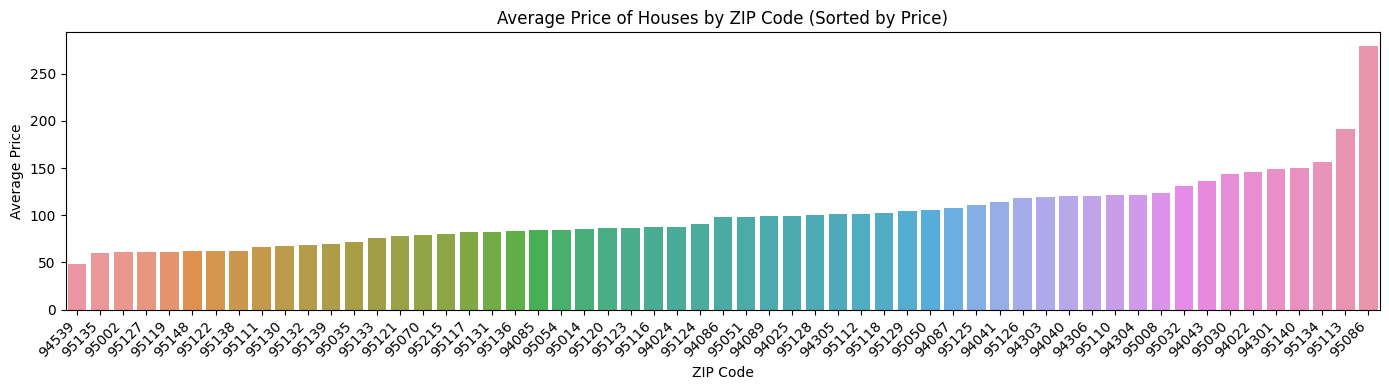

In [41]:
# Calculate the average price by ZIP code and sort by price
zipcode_avg_price = df.groupby('zipcode')['price'].mean().reset_index()
zipcode_avg_price = zipcode_avg_price.sort_values(by='price')

# Create a bar plot of the average price of units by ZIP code
plt.figure(figsize=(14, 4))  # Adjust the figure size
sns.barplot(x='zipcode', y='price', data=zipcode_avg_price, errorbar=None)  # Use 'zipcode' on the x-axis and 'price' on the y-axis
plt.xlabel('ZIP Code')
plt.ylabel('Average Price')
plt.title('Average Price of Houses by ZIP Code (Sorted by Price)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and adjust alignment
plt.tight_layout()  # Ensure labels fit within the plot
plt.show()

Next, we want to see the count of each ZIP code using the barplot below:

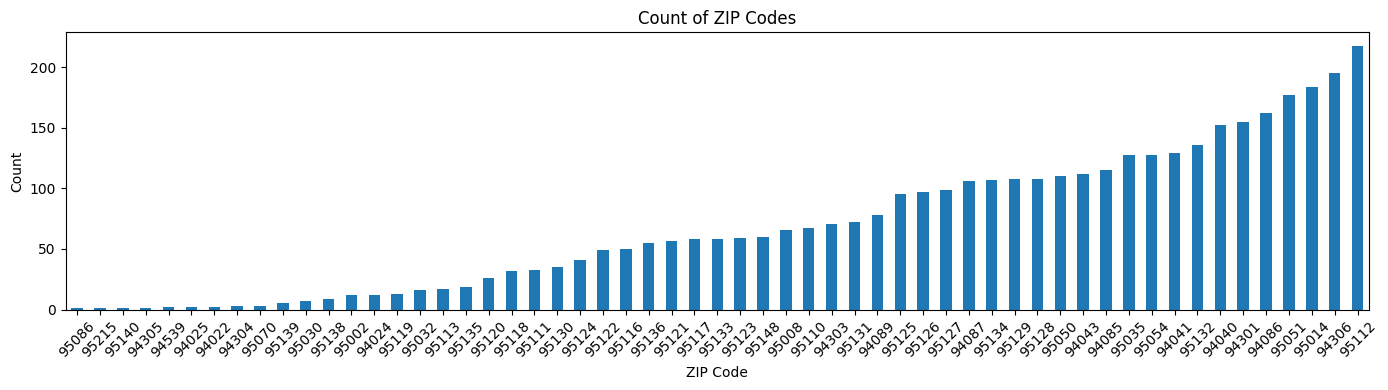

In [42]:
# Count the occurrences of each ZIP code
zipcode_counts = df['zipcode'].value_counts()

# Sort the counts by the count of ZIP codes in increasing order
zipcode_counts_sorted = zipcode_counts.sort_values(ascending=True)

# Create a bar plot to visualize the count of ZIP codes in increasing order of count
plt.figure(figsize=(14, 4))
zipcode_counts_sorted.plot(kind='bar')
plt.xlabel('ZIP Code')
plt.ylabel('Count')
plt.title('Count of ZIP Codes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As we can see, there are quite a few outlying ZIP codes that occur very few times. Although we won't be using the `zipcode` column in our model directly, filtering the rows based on `zipcode` occurrence helps to improve model performance. Below, we remove ZIP codes that occur fewer than 20 times. 

In [43]:
# Count the occurrences of each ZIP code
zipcode_counts = df['zipcode'].value_counts()

# Create a mask to filter out ZIP codes occurring less than 20 times
mask = df['zipcode'].map(zipcode_counts) >= 20

# Apply the mask to the DataFrame to keep only the desired rows
df = df[mask]
df.reset_index(drop=True, inplace=True)

## 9. Looking at the relationship between `price` and `beds`

Like the `zipcode` column, we will not be using the `beds` column as input into the final model. However, it is helpful to remove outliers that occur in the `beds` column to improve model performance.

Below, we plot `price` by `beds`, and get a reasonably linear relationship. As is evident in the plot, around 5 beds is where a lot of variability is introduced.

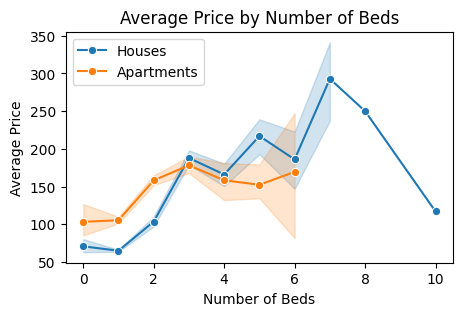

In [44]:
plt.figure(figsize=(5, 3))

# Filter the DataFrame for houses and apartments
df_houses = df[df['property_type'] == 'House']
df_apartments = df[df['property_type'] == 'Apartment']

# Create line plots for average price by number of beds for both houses and apartments
sns.lineplot(data=df_houses, x='beds', y='price', estimator='mean', marker='o', label='Houses')
sns.lineplot(data=df_apartments, x='beds', y='price', estimator='mean', marker='o', label='Apartments')

plt.xlabel('Number of Beds')
plt.ylabel('Average Price')
plt.title('Average Price by Number of Beds')
plt.legend()

plt.show()

To control the influence of outliers, we filter out rows where `beds` is 5 or greater. These listings make up a small proportion of all listings, and introduce significant noise.

In [45]:
# Count the total number of houses and apartments with more than four beds
total_houses_and_apartments = ((df['property_type'] == 'House') | (df['property_type'] == 'Apartment'))  # Filter houses and apartments
more_than_four_beds = df['beds'] > 4  # Filter for more than four beds

# Apply both filters and count the rows
count = (total_houses_and_apartments & more_than_four_beds).sum()

print("Total number of houses and apartments with five or more beds:", count)

Total number of houses and apartments with five or more beds: 87


In [46]:
# filter out places with 5 or more beds
df = df[df['beds'] < 5]

## 10. Looking at `cleaning_fee` and `price`: Which depends on which?

We now turn our attention to the `cleaning_fee`. First, we clean the column and convert the string values to numerics. Then we impute missing cleaning fees with the average cleaning fee.

In [47]:
df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)

# Convert the price column to numeric
df['cleaning_fee'] = pd.to_numeric(df['cleaning_fee'])

# Count the number of NaN values in the 'cleaning_fee' column
nan_count = df['cleaning_fee'].isna().sum()

print(f'Number of NaN values in the "cleaning_fee" column: {nan_count}')

Number of NaN values in the "cleaning_fee" column: 363


In [48]:
# Calculate the average cleaning fee (excluding NaNs)
average_cleaning_fee = df['cleaning_fee'].apply(pd.to_numeric, errors='coerce').mean()

# Replace NaN values in the 'cleaning_fee' column with the average cleaning fee
df['cleaning_fee'].fillna(average_cleaning_fee, inplace=True)

The relationship between `price` and `cleaning_fee` shown in the scatterplot below is roughly linear:

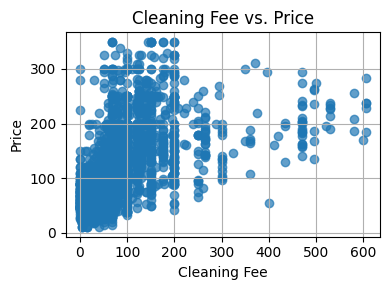

In [49]:
plt.figure(figsize=(4, 3))  # Adjust the figure size
plt.scatter(df['cleaning_fee'], df['price'], alpha=0.7)
plt.xlabel('Cleaning Fee')
plt.ylabel('Price')
plt.title('Cleaning Fee vs. Price')
plt.grid(True)
plt.tight_layout()
plt.show()

It turns out that including the `cleaning_fee` in our model, notwithstanding its linear relationship with `price`, does *not* significantly improve model performance. For that reason, we leave it out. Furthermore, it is probably the case that it is not the `cleaning_fee` in and of itself that is *causing* an increase in `price`; rather, higher `price` values entail higher `cleaning_fee` values. 

For this reason, we don't include it in the model, because we do not want to ask the user to input a cleaning fee, only for arbitrarily high cleaning fees to cause the model to return artificially high prices. 

**Footnote:** *In fact, there has been great debate and public discontent regarding Airbnb's high cleaning fees. Is it possible that certain models have been incorporating cleaning fees as a price predictor? For more, see: https://www.nerdwallet.com/article/travel/airbnb-has-a-plan-to-fix-cleaning-fees*

## 11. The amount of guests accommodated is correlated to `price`

The `guests_included` column indicates how many guests the owner will allow to stay at the unit. It is *not* a boolean value. As can be see in the scatterplot below, there is a certain linear relationship. Of particular note is the clearly linear price floor that increases as `guests_included` rises.

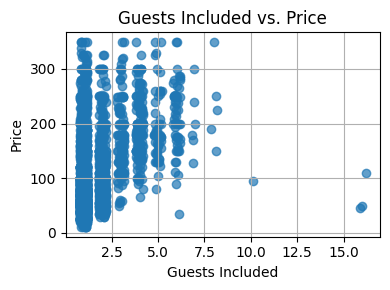

In [50]:
plt.figure(figsize=(4, 3))
plt.scatter(df['guests_included']+ np.random.uniform(-0.2, 0.2, len(df)), df['price'], alpha=0.7)
plt.xlabel('Guests Included')
plt.ylabel('Price')
plt.title('Guests Included vs. Price')
plt.grid(True)
plt.tight_layout()
plt.show()

## 12. Getting finer-grained detail with `amenities`

The `amenities` column contains a wealth of fine-grained boolean information about units, such as the presence / absence of pools, appliances, hot tubs, and even doormen. Below is a sample of the first listing's amenities:

In [51]:
df.amenities[0]

'{TV,"Cable TV",Internet,Wifi,"Pets live on this property",Dog(s),"Free street parking",Heating,"Family/kid friendly","Smoke alarm","Carbon monoxide alarm","First aid kit",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop-friendly workspace","translation missing: en.hosting_amenity_50","Hot water","Coffee maker","Dishes and silverware","EV charger","Garden or backyard","Luggage dropoff allowed","Long term stays allowed","Cleaning before checkout","Host greets you"}'

To effectively work with the `amenities` column, we begin by stripping away the formatting, which includes:
- removing curly braces
- removing quotations
- splitting the strings by comma into lists
- getting rid of amenities that are missing a translation 

In [52]:
# Clean and split the 'amenities' column
df['amenities'] = df['amenities'].str.strip('{}')  # Remove curly braces
df['amenities'] = df['amenities'].str.replace('"', '')  # Remove quotes
df['amenities'] = df['amenities'].str.split(',')  # Split by commas

# Function to remove items containing 'translation missing' from a list
def clean_amenities(amenities_list):
    if amenities_list is not None:
        # Convert each item to lowercase
        cleaned_amenities = [item.lower() for item in amenities_list if 'translation missing' not in item]
        return cleaned_amenities
    else:
        return None

# Apply the cleaning function to the 'amenities' column
df['amenities'] = df['amenities'].apply(clean_amenities)

A first question of interest that I wanted to examine was whether certain amenities were superficially more common for low-priced, mid-priced, and high-priced units. It turns out that some amenities are so common that they constitute the top amenities of a unit regardless of `price`. This can be seen in the printout below:

In [53]:
# Define price ranges 
price_ranges = [(0, 75), (75, 200), (200, 500)]

# Function to categorize prices into ranges
def categorize_price(price):
    for low, high in price_ranges:
        if low <= price <= high:
            return f'{low}-{high}'
    return 'Above 500'

# Apply the price categorization
df['price_range'] = df['price'].apply(categorize_price)

# Create a DataFrame to store amenity occurrence counts by price range
amenity_occurrence = df.groupby('price_range')['amenities'].apply(lambda x: pd.Series([item for sublist in x for item in sublist]).value_counts(normalize=True))

# Select the top 5 amenities for each price range
top_5_amenities = amenity_occurrence.groupby(level=0).head(5)

# Iterate through price ranges and print the top 5 amenities
for price_range, top_amenities in top_5_amenities.groupby(level=0):
    top_amenities_list = ', '.join([str(item[1]) for item in top_amenities.index.tolist()])
    print(f"Price Range: {price_range} {top_amenities_list}")

Price Range: 0-75 wifi, essentials, heating, smoke alarm, hangers
Price Range: 200-500 smoke alarm, wifi, heating, essentials, kitchen
Price Range: 75-200 wifi, essentials, heating, smoke alarm, hangers


To get a better idea of what amenities are available, it is possible to flatten out the amenities column into a list, and count how many of each amenity occur.

In [54]:
# Flatten the list of amenities
all_amenities = [item for sublist in df['amenities'] for item in sublist]

# Count the occurrences of each unique item
amenities_counts = pd.Series(all_amenities).value_counts()

# Define the batch size (number of items to display per batch)
batch_size = 10

# Display the counts in smaller batches
for i in range(0, len(amenities_counts), batch_size):
    batch = amenities_counts.iloc[i:i + batch_size]
    print(batch)

wifi                         3596
essentials                   3493
heating                      3458
smoke alarm                  3448
hangers                      3253
carbon monoxide alarm        3106
shampoo                      3096
kitchen                      2990
washer                       2976
laptop-friendly workspace    2972
dtype: int64
hair dryer                  2964
dryer                       2957
iron                        2833
free parking on premises    2654
hot water                   2642
tv                          2421
microwave                   2222
refrigerator                2216
free street parking         2204
fire extinguisher           2144
dtype: int64
air conditioning         2133
lock on bedroom door     2017
dishes and silverware    2008
coffee maker             1852
first aid kit            1830
bed linens               1750
oven                     1702
self check-in            1669
stove                    1662
cooking basics           1645
dtyp

We can see that property prices have different price means based on whether they have a kitchen or not.

In [55]:
# Filter rows where "kitchen" is present in amenities
has_kitchen = df['amenities'].apply(lambda x: 'kitchen' in x)
no_kitchen= df['amenities'].apply(lambda x: 'kitchen' not in x)

# Calculate the average price for houses and apartments with a kitchen
average_price_with_kitchen = df[has_kitchen].groupby('property_type')['price'].mean()
average_price_without_kitchen = df[no_kitchen].groupby('property_type')['price'].mean()

# Display the average prices
print(average_price_with_kitchen)
print(average_price_without_kitchen)

property_type
Apartment    133.579481
House         92.896339
Name: price, dtype: float64
property_type
Apartment    84.831325
House        68.718213
Name: price, dtype: float64


Following this observation, we can isolate certain amenities and turn them into boolean columns to use in our model. Some of the most impactful are `has_balcony`, `has_hot_tub`, and `has_elevator`.

In [56]:
# Create a new column 'has_amenity' with 1 if 'amenity' is in amenities, 0 otherwise
df['has_kitchen'] = df['amenities'].apply(lambda x: 1 if 'kitchen' in x else 0)

df['has_pool'] = df['amenities'].apply(lambda x: 1 if 'pool' in x else 0)

df['has_balcony'] = df['amenities'].apply(lambda x: 1 if 'balcony' in x else 0)

df['has_gym'] = df['amenities'].apply(lambda x: 1 if 'gym' in x else 0)

df['has_dishwasher'] = df['amenities'].apply(lambda x: 1 if 'dishwasher' in x else 0)

df['has_hot_tub'] = df['amenities'].apply(lambda x: 1 if 'hot tub' in x else 0)

df['has_bbq'] = df['amenities'].apply(lambda x: 1 if 'bbq grill' in x else 0)

df['has_elevator'] = df['amenities'].apply(lambda x: 1 if 'elevator' in x else 0)

df['has_private_entrance'] = df['amenities'].apply(lambda x: 1 if 'private entrance' in x else 0)

# Part 2. Building the model

For our MVP, we will make use of a multiple linear regression model, since our input variables are linearly correlated to price. The model will help capture how much impact each input variable has on the output, price.

We begin by choosing which input variables to keep. These variables are chosen based on how well they help predict price. The `price` column is included, but of course we will separate it from the inputs.

In [57]:
# Define columns to keep
columns_to_keep = ['neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'price', 'latitude', 'longitude', 'guests_included', 'has_kitchen', 'has_pool', 'has_balcony', 'has_gym', 'has_dishwasher', 'has_hot_tub', 'has_elevator', 'has_private_entrance']

# Select the columns to keep and reset the index
df = df[columns_to_keep].reset_index(drop=True)

Next, we verify that our data matrix does not contain any `NaN`s.

In [58]:
# Calculate the percentage of NaN values in each column
percentage_nan = (df.isna().mean() * 100).round(2)

print("Percentage of NaN values in each column:")
print(percentage_nan)

Percentage of NaN values in each column:
neighbourhood_cleansed    0.0
property_type             0.0
room_type                 0.0
accommodates              0.0
bedrooms                  0.0
price                     0.0
latitude                  0.0
longitude                 0.0
guests_included           0.0
has_kitchen               0.0
has_pool                  0.0
has_balcony               0.0
has_gym                   0.0
has_dishwasher            0.0
has_hot_tub               0.0
has_elevator              0.0
has_private_entrance      0.0
dtype: float64


Next, we transform our categorical variables into usable numerics via the `.get_dummies()` method. Following this step, we can split our input variables from our output variable `price`. Lastly, we split the data into training and test sets.

In [59]:
df = pd.get_dummies(df, columns=['neighbourhood_cleansed', 'property_type', 'room_type'], prefix=['neigh', 'prop', 'room'])

y= df['price']
X= df.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We fit our model according to the training data, and test it using `.predict()`.

In [60]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Lastly, to judge our model's performance, we get the MSE (mean-squared error) score and the R² score. 

In [61]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 862.77
R-squared (R²): 0.78


### Interpreting the MSE (Mean Squared Error) score

The MSE score is used to quantify the goodness of fit or the accuracy of our linear regression model. It captures the average squared difference between the actual (observed) values and the predicted values produced by the model. In other words, it measures the average squared "error" or "residual" between the predicted and actual values.

We can interpret the MSE score of `862.77` as being in dollars squared. By taking the square root of this value, we get `$29.38`. This means that the model's predictions have an error or deviation from the actual values of approximately `$29.38` when predicting prices in dollars.

### Interpreting the R² score

The R² score is calculated by comparing the variability explained by our regression model to the total variability in the dependent variable, `price`. It quantifies the proportion of the variance in the dependent variable that the model can account for. 

Under the hood, the R² score is calculated by measuring the total variance (TSS - total sum of squares) by summing the squared differences between each data point's y-value and the mean y-value. Then, the explained variance (ESS - explained sum of squares) is calculated by comparing the predicted y-values from the model to the mean y-value and squaring the differences. Lastly, R² is designated as the ratio of ESS to TSS, with values ranging from 0 (poor fit) to 1 (perfect fit). A higher R² indicates that the model explains more of the variance, suggesting a better fit to the data.

In our case, our R² score of `0.78` can be interpreted as meaning that approximately 78% of the variance in the target variable `price` is explained by the independent variables included in our regression model (i.e. `neighbourhood_cleansed`, `bedrooms`, etc.). In other words, an R² of `0.78` means that approximately 78% of the variability in the target variable's values can be accounted for by the predictor variables in our model.

This high R² score suggests that our multiple linear regression model does a good job of capturing and explaining the patterns and variations in the Airbnb data. In practical terms, it implies that the model's predictions are effective in explaining and predicting the observed outcomes, as it accounts for a substantial portion of the variance. However, there is still be some unexplained variability (22% in this case) that the model does not account for. 

### How much impact does each input variable have?

To see the unique role each of our input variables has in predict a listing's `price` value, we can print out the model coefficients.

In [62]:
coefficients = model.coef_

print("Coefficients (Weights):")
for feature, coef in zip(X_train.columns, coefficients):
    print(f"{feature}: {coef}")

Coefficients (Weights):
accommodates: 6.412635861263249
bedrooms: 20.881203373938796
latitude: 7.782351489262317
longitude: -41.87651105454844
guests_included: 1.5373392038476013
has_kitchen: -2.318757215517326
has_pool: 2.0186604068981575
has_balcony: 18.170526599796787
has_gym: 2.8518737582392584
has_dishwasher: 4.165088892328994
has_hot_tub: 11.666572995426467
has_elevator: 17.48971491786854
has_private_entrance: -3.493858102402351
neigh_Campbell: 5.554110767819115
neigh_Cupertino: -3.674031063522195
neigh_Los Altos: 8.881784197001252e-15
neigh_Los Gatos: 7.8497993820715575
neigh_Milpitas: -4.567415510803906
neigh_Mountain View: -3.5137611612445063
neigh_Palo Alto: 6.065718186868407
neigh_San Jose: 1.1240265531827704
neigh_Santa Clara: 1.8147155697137385
neigh_Sunnyvale: -1.6766625911556141
neigh_Unincorporated Areas: -8.976500132929742
prop_Apartment: -4.906196194322442
prop_House: 4.906196194322508
room_Entire home/apt: 58.55883477073598
room_Private room: -12.639017349547315
room

By looking at the coefficients, we can see that some input variables have a heavier impact on predicting `price` than others. For example, `bedrooms`, `has_elevator`, and interestingly, `longitude` have a strong prediction impact. The role of `longitude` in prediction may reflect strong pricing differences between the southern/eastern and western parts of Santa Clara County. Also, noting the differences between `room_type` coefficients indicates that `room_type` plays a substantive role in predicting `price`.

# Part 3. Seeing the model in action

In order to see the model in action, we need to create novel vectors that represent hypothetical Airbnb properties that a user wants to get a price estimate for.

We begin by writing functions to generate a random latitude and longitude for a given neighborhood (of course if this model were to be deployed in real life, the latitude and longitude would be calculate based on property address).

In [63]:
# Get a random latitude for a given neighborhood
def get_latitude(neigh):
    neigh= f'neigh_{neigh}'
    min_lat = df[df[neigh] == 1]['latitude'].min()
    max_lat = df[df[neigh] == 1]['latitude'].max()
    return random.uniform(min_lat, max_lat)

# Get a random longitude for a given neighborhood
def get_longitude(neigh):
    neigh= f'neigh_{neigh}'
    min_lon = df[df[neigh] == 1]['longitude'].min()
    max_lon = df[df[neigh] == 1]['longitude'].max()
    return random.uniform(min_lon, max_lon)

Next, we define all the features that our test vectors must have:

In [64]:
# Define the feature names that match the order of the test data
feature_names = ['accommodates', 'bedrooms', 'latitude', 'longitude',
                 'guests_included', 'has_kitchen', 'has_pool', 'has_balcony', 'has_gym',
                 'has_dishwasher', 'has_hot_tub', 'has_elevator', 'has_private_entrance',
                 'neigh_Campbell', 'neigh_Cupertino', 'neigh_Los Altos',
                 'neigh_Los Gatos', 'neigh_Milpitas', 'neigh_Mountain View',
                 'neigh_Palo Alto', 'neigh_San Jose', 'neigh_Santa Clara',
                 'neigh_Sunnyvale', 'neigh_Unincorporated Areas', 'prop_Apartment',
                 'prop_House', 'room_Entire home/apt', 'room_Private room',
                 'room_Shared room']

Now we write a function `.create_test_vector()` that takes in a dictionary of feature-value pairs. The function automatically fills out the OHE-encoded neighborhoods based on the neighborhood provided, as well as the property and room types. Additionally, it automatically assigns a random latitude and longitude to the test vector based on the neighborhood, using the functions we defined at the top of the section.

In [65]:
def create_test_vector(features):
    # Initialize a dictionary with zeros
    test_dict = {feature: 0 for feature in feature_names}
    
    for feature_name, value in features.items():
        if feature_name == 'neighborhood':
            # Special handling for the neighborhood feature
            test_dict[f'neigh_{value}'] = 1
            
            # Fill out latitude and longitude randomly generated based on neighborhood
            lat = get_latitude(value)
            lon = get_longitude(value)
            test_dict['latitude'] = lat
            test_dict['longitude'] = lon
            
        elif feature_name == 'property_type':
            # Special handling for the property_type feature
            test_dict[f'prop_{value}'] = 1
            
        elif feature_name == 'room_type':
            # Special handling for the room_type feature
            test_dict[f'room_{value}'] = 1
            
        else:
            # Set the value of other features based on feature names
            test_dict[feature_name] = value
            
    # Create DataFrame from dictionary
    test_df = pd.DataFrame([test_dict])
    
    return test_df

This function takes in the test vector, runs in through the model, and generates a price estimate:

In [66]:
def get_price_estimate(test_df):
    y_pred_test= model.predict(test_df)
    return y_pred_test

### Example 1. An entire 1bd apartment in Cupertino (mid-price example)

This test vector represents a entire 1bd apartment in Cupertino, that accommodates 2 people, 2 guests, and has a kitchen:

In [67]:
test_features_ex1 = {
    'accommodates': 2,
    'bedrooms': 1,
    'guests_included': 2,
    'has_kitchen': 1,
    'has_pool': 0,
    'has_balcony': 0,
    'has_gym': 0,
    'has_dishwasher': 0, 
    'has_hot_tub': 0, 
    'has_elevator': 0, 
    'has_private_entrance': 0,
    'neighborhood': 'Cupertino', 
    'property_type': 'Apartment',  
    'room_type': 'Entire home/apt',  
}

test_df_ex1 = create_test_vector(test_features_ex1)

We get the price estimate for the property and format it:

In [68]:
print(f"${round(get_price_estimate(test_df_ex1)[0], 2)}")

$128.59


### Example 2. An entire 3bd house in Los Altos (high-price example)

In this example we estimate the price for an entire 3bd house in Los Altos:

In [69]:
test_features_ex2 = {
    'accommodates': 6,
    'bedrooms': 3,
    'guests_included': 6,
    'has_kitchen': 1,
    'has_pool': 1,
    'has_balcony': 1,
    'has_gym': 0,
    'has_dishwasher': 1, 
    'has_hot_tub': 1, 
    'has_elevator': 0, 
    'has_private_entrance': 1,
    'neighborhood': 'Los Altos', 
    'property_type': 'House',  
    'room_type': 'Entire home/apt',  
}

test_df_ex2 = create_test_vector(test_features_ex2)

In [70]:
print(f"${round(get_price_estimate(test_df_ex2)[0], 2)}")

$258.17


### Example 3. A private room in a 2bd apartment in Milpitas (low-price example)

Lastly, as a low-price example, we test a hypothetical private room in a 2bd Milpitas apartment.

In [71]:
test_features_ex3 = {
    'accommodates': 1,
    'bedrooms': 0,
    'guests_included': 1,
    'has_kitchen': 0,
    'has_pool': 0,
    'has_balcony': 0,
    'has_gym': 0,
    'has_dishwasher': 1, 
    'has_hot_tub': 0, 
    'has_elevator': 1, 
    'has_private_entrance': 0,
    'neighborhood': 'Milpitas', 
    'property_type': 'Apartment',  
    'room_type': 'Private room',  
}

test_df_ex3 = create_test_vector(test_features_ex3)

In [72]:
print(f"${round(get_price_estimate(test_df_ex3)[0], 2)}")

$43.21


From these three tests, we can see that the model does a good job at distinguishing price tiers based on property features.

# Part 4. Improvement opportunities

### Using square footage as a predictor variable
This model still fails to capture about 22% of the variance in the data. One way to improve the model's ability to estimate prices would be to include square footage as an input variable. Although this dataset did in fact have a `square_feet` column, it contained very few values and the rest were `NaN`s. For this reason, it was not included in the model. Generally, price is a strong correlate to square footage in real estate.


### Increasing the size of the dataset and computational resources
Naturally, the model could be improved by increasing this size of the dataset. Because this model had to be developed and trained on my personal machine, the computational resources for training were limited. However, with HPC resources and a much larger dataset, the model could be further refined. Additionally, with a larger dataset, other property types such as condos and guest houses could be included in the model.

### Doing a deeper dive into NLP cues
Lastly, doing a thorough natural language processing analysis on the textual columns (such as `description`, `summary`, `neighbourhood_overview`, `transit`, and others) to extract linguistic cues that correlate with price could be an avenue to improve model performance. Extracting linuistic information proved to be useful when we retrieved boolean values from `amenities`. One approach could split properties up into price tiers and associate linguistic particularities with each.